<a href="https://colab.research.google.com/github/Park-hanna/BDA_study/blob/main/Forecasting/Employee_external_analysis_using_HR_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Employee external analysis using HR data

In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

# Plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from imblearn.over_sampling import SMOTE
import xgboost

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
attrition = pd.read_csv('/content/drive/MyDrive/Data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
attrition.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [ ]:
print(attrition.shape)

(1470, 35)


In [ ]:
display(attrition.isnull().any())

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

In [ ]:
print('duplication values : ', len(attrition[attrition.duplicated()]))

duplication values :  0


In [ ]:
target_map = {'Yes':1, 'No':0}

attrition['Attrition_numerical'] = attrition['Attrition'].apply(lambda x: target_map[x])
attrition['Attrition_numerical'].value_counts()

0    1233
1     237
Name: Attrition_numerical, dtype: int64

In [ ]:
y = attrition['Attrition'].copy()
y = y.isin(['Yes']).astype('int')
y.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

In [ ]:
print(attrition.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [ ]:
dtype_data = attrition.dtypes.reset_index()
dtype_data.columns = ['Count', 'Column Type']
dtype_data = dtype_data.groupby('Column Type').aggregate('count').reset_index()

print(dtype_data)

  Column Type  Count
0       int64     27
1      object      9


## Categorical Feature

In [ ]:
attrition.select_dtypes(include=['object', 'category']).head()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No


In [ ]:
cat_feat = attrition.select_dtypes('object', 'category').columns.values
attrition_cat = attrition[cat_feat].copy()
print(attrition_cat.nunique().sort_values())

Over18            1
Attrition         2
Gender            2
OverTime          2
BusinessTravel    3
Department        3
MaritalStatus     3
EducationField    6
JobRole           9
dtype: int64


In [ ]:
attrition_cat = attrition_cat.drop(['Over18', 'Attrition'], axis = 1, errors = 'ignore')

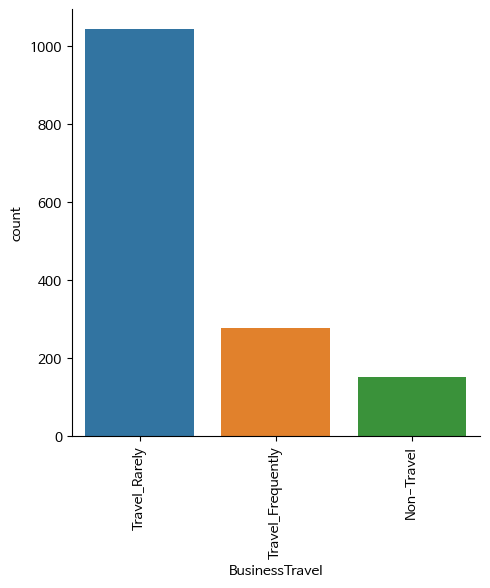

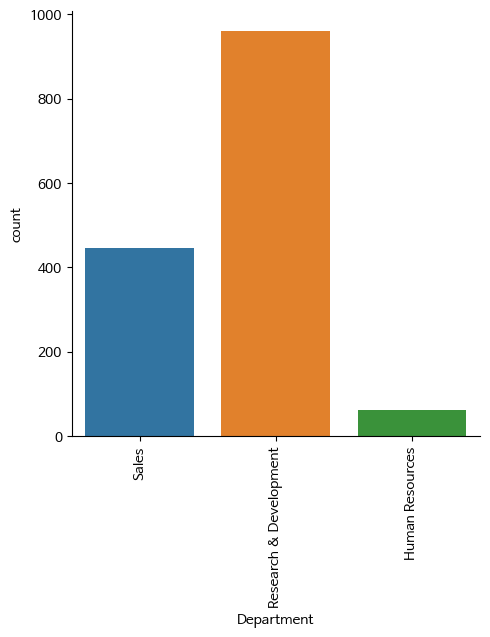

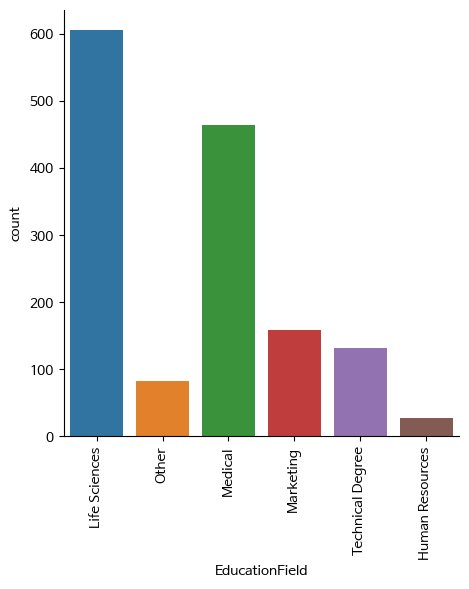

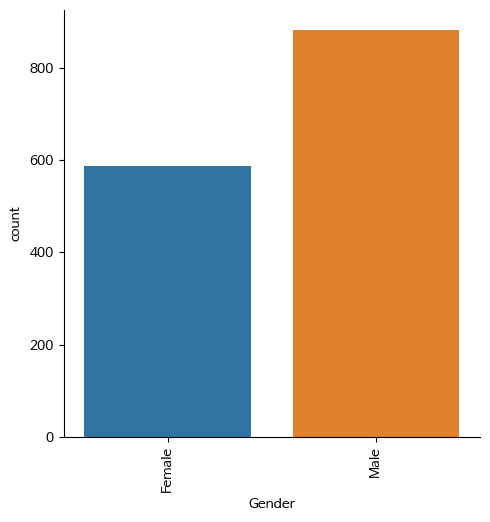

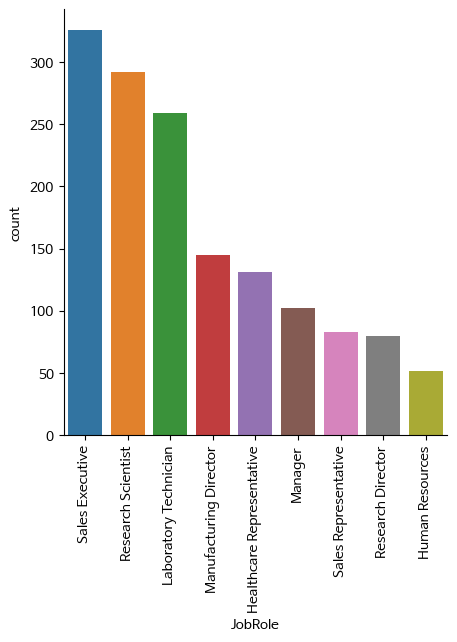

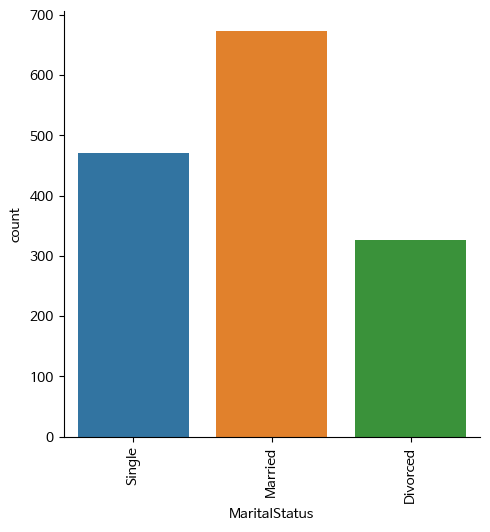

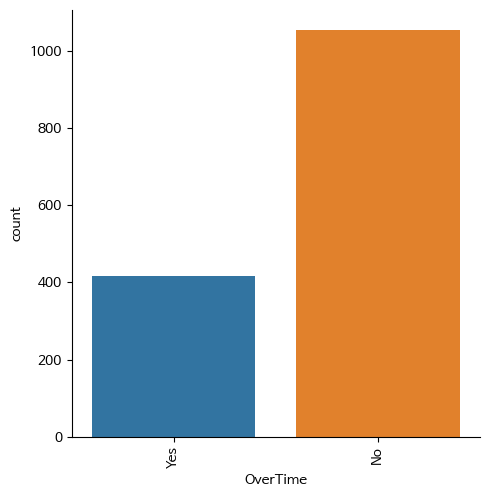

In [ ]:
for col in attrition_cat.columns:
  fig = sns.catplot(x=col, kind="count", data=attrition_cat, hue=None)
  fig.set_xticklabels(rotation=90)
  plt.show()

In [ ]:
attrition_cat_dummies = pd.get_dummies(attrition_cat)
attrition_cat_dummies.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
attrition_cat_ohe = ohe.fit_transform(attrition_cat).toarray()
attrition_cat_ohe = pd.DataFrame(attrition_cat_ohe)
attrition_cat_ohe.columns = ['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'OverTime_No', 'OverTime_Yes']

print("OneHot Encoder 결과 : ")
print(attrition_cat_ohe.iloc[:,:2])

OneHot Encoder 결과 : 
      BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently
0                           0.0                               0.0
1                           0.0                               1.0
2                           0.0                               0.0
3                           0.0                               1.0
4                           0.0                               0.0
...                         ...                               ...
1465                        0.0                               1.0
1466                        0.0                               0.0
1467                        0.0                               0.0
1468                        0.0                               1.0
1469                        0.0                               0.0

[1470 rows x 2 columns]


## Numeric Feature

In [ ]:
attrition.select_dtypes(include = ['number']).head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_numerical
0,41,1102,1,2,1,1,2,94,3,2,...,80,0,8,0,1,6,4,0,5,1
1,49,279,8,1,1,2,3,61,2,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1373,2,2,1,4,4,92,2,1,...,80,0,7,3,3,0,0,0,0,1
3,33,1392,3,4,1,5,4,56,3,1,...,80,0,8,3,3,8,7,3,0,0
4,27,591,2,1,1,7,1,40,3,1,...,80,1,6,3,3,2,2,2,2,0


In [ ]:
attrition.select_dtypes(include = np.number).head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_numerical
0,41,1102,1,2,1,1,2,94,3,2,...,80,0,8,0,1,6,4,0,5,1
1,49,279,8,1,1,2,3,61,2,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1373,2,2,1,4,4,92,2,1,...,80,0,7,3,3,0,0,0,0,1
3,33,1392,3,4,1,5,4,56,3,1,...,80,0,8,3,3,8,7,3,0,0
4,27,591,2,1,1,7,1,40,3,1,...,80,1,6,3,3,2,2,2,2,0


In [ ]:
num_feat = attrition.select_dtypes('number').columns.values
attrition_num = attrition[num_feat].copy()

In [ ]:
print(attrition_num.nunique().sort_values())

EmployeeCount                  1
StandardHours                  1
Attrition_numerical            2
PerformanceRating              2
WorkLifeBalance                4
StockOptionLevel               4
EnvironmentSatisfaction        4
JobInvolvement                 4
JobSatisfaction                4
RelationshipSatisfaction       4
Education                      5
JobLevel                       5
TrainingTimesLastYear          7
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate                    71
DailyRate                    886
MonthlyIncome               1349
MonthlyRate                 1427
EmployeeNumber              1470
dtype: int64


In [ ]:
print(attrition.shape)

(1470, 36)


In [ ]:
attrition_num = attrition_num.drop(['StandardHours', 'EmployeeCount', 'EmployeeNumber', 'Attrition_numerical'], axis = 1, errors='ignore')

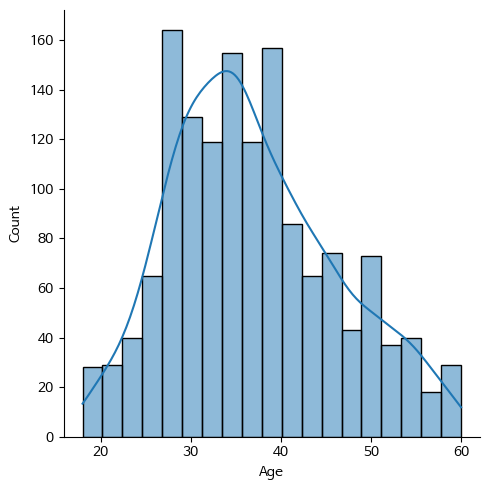

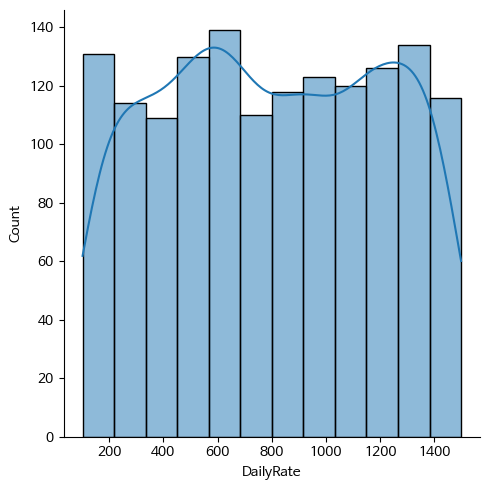

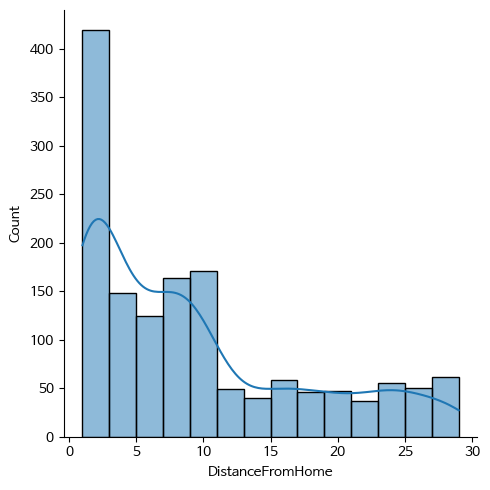

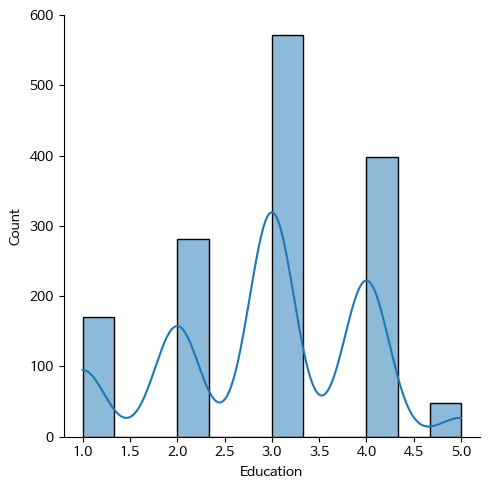

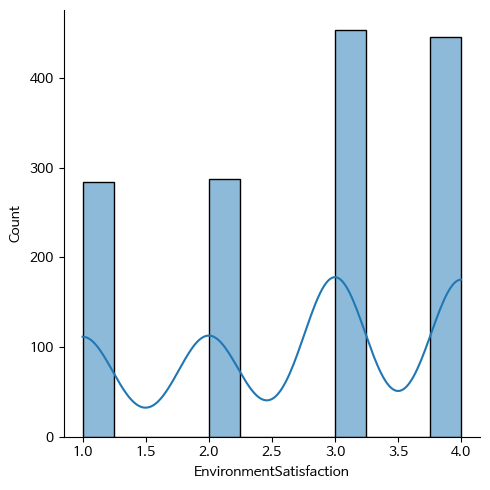

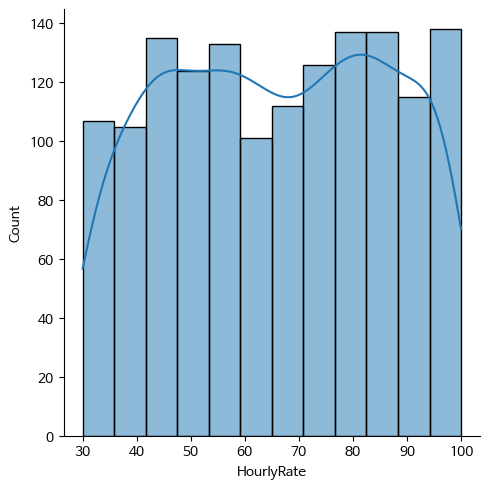

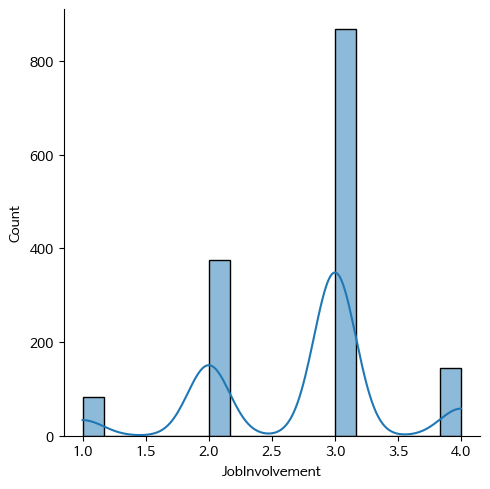

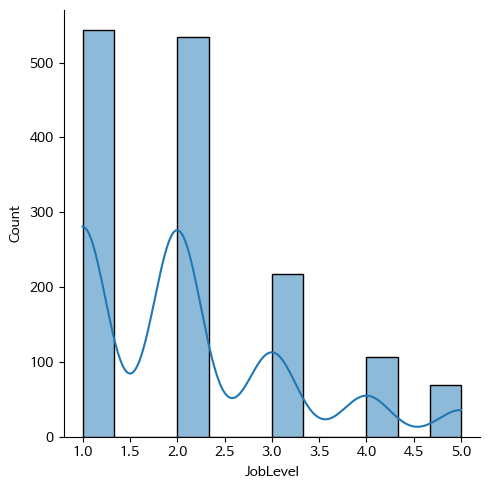

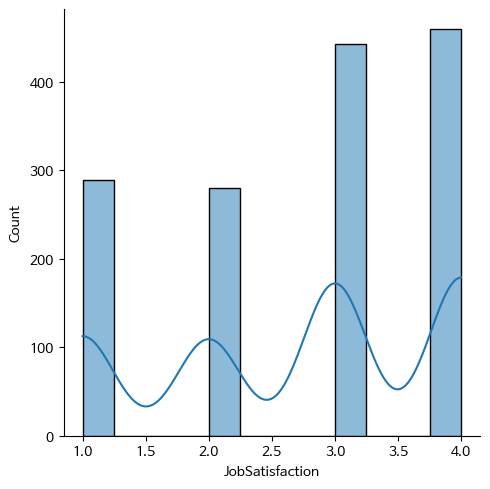

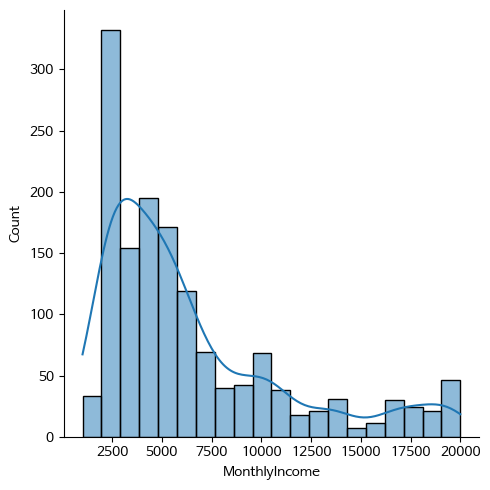

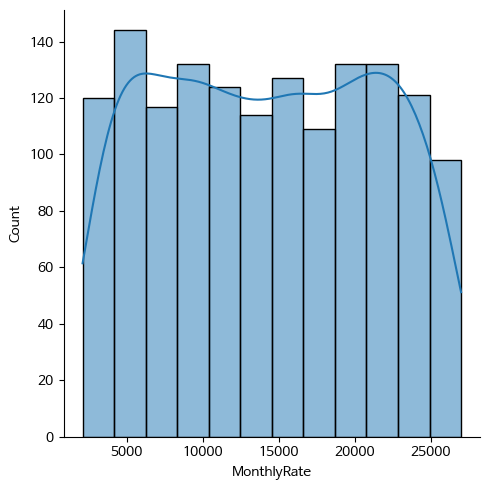

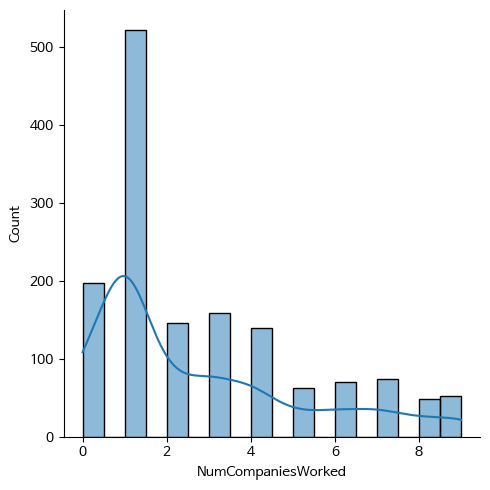

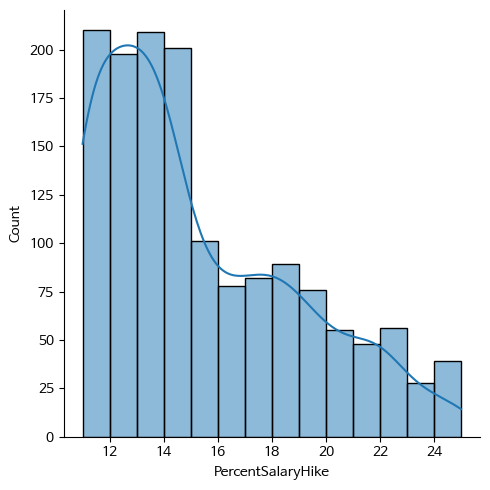

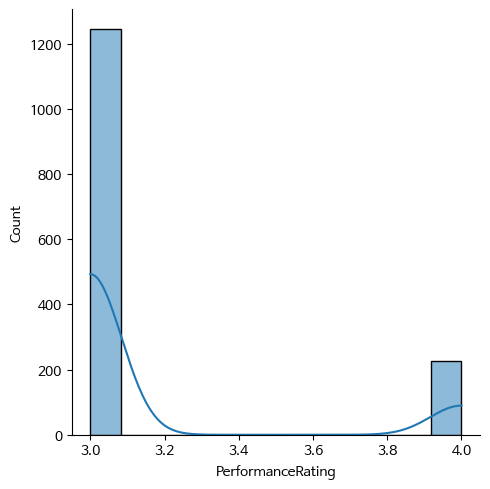

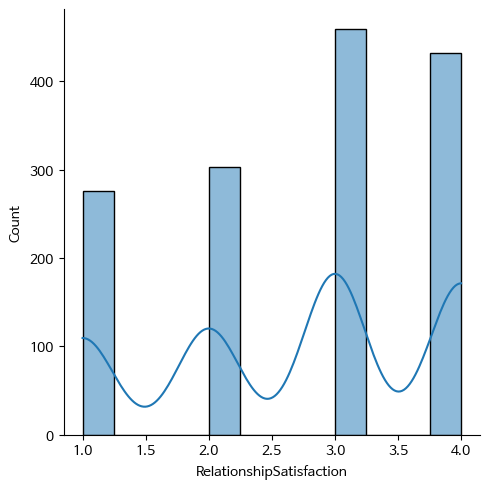

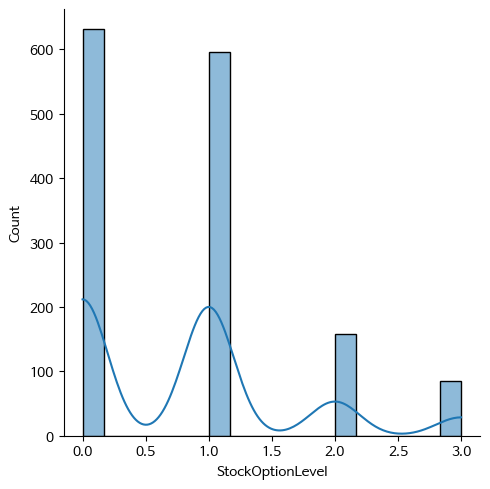

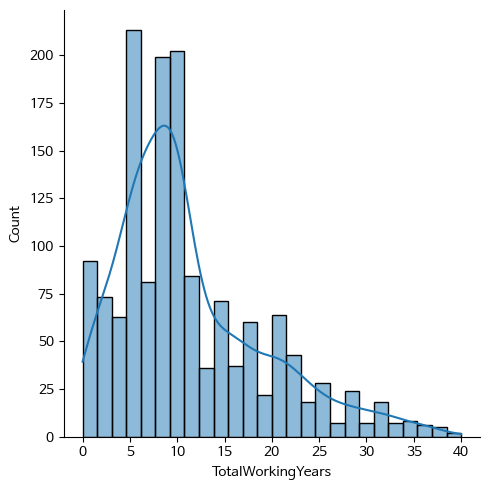

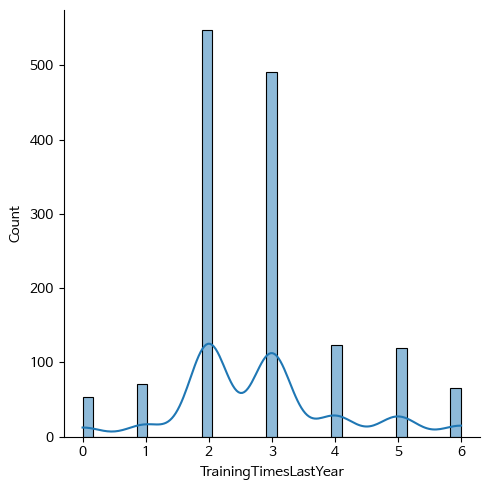

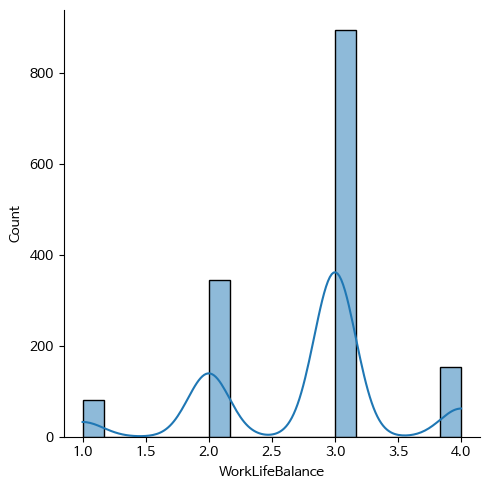

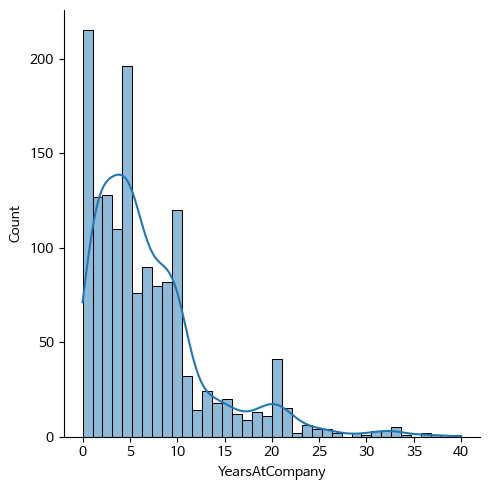

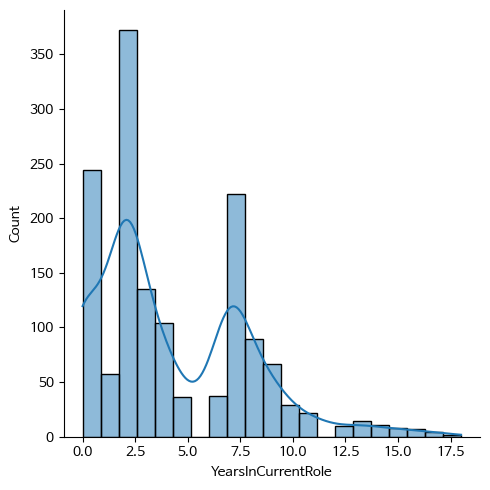

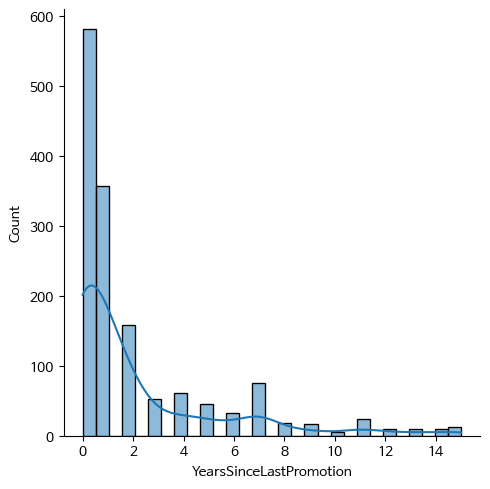

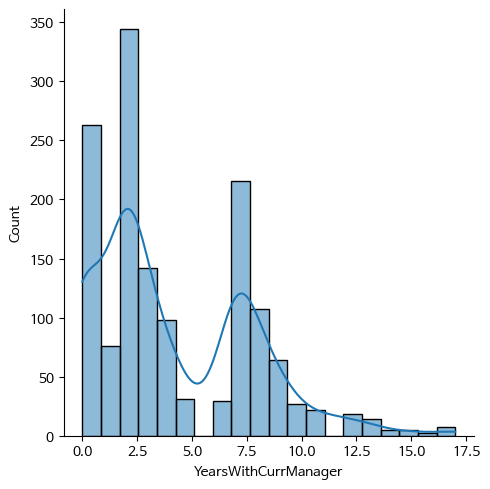

In [ ]:
col_attrition_num = attrition_num.columns.values
for i in range(0, len(col_attrition_num)):
  sns.displot(attrition_num[col_attrition_num[i]], kde=True)

## relation feature

In [ ]:
attrition_num.nunique().sort_values()

PerformanceRating              2
WorkLifeBalance                4
EnvironmentSatisfaction        4
StockOptionLevel               4
JobInvolvement                 4
JobSatisfaction                4
RelationshipSatisfaction       4
Education                      5
JobLevel                       5
TrainingTimesLastYear          7
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate                    71
DailyRate                    886
MonthlyIncome               1349
MonthlyRate                 1427
dtype: int64

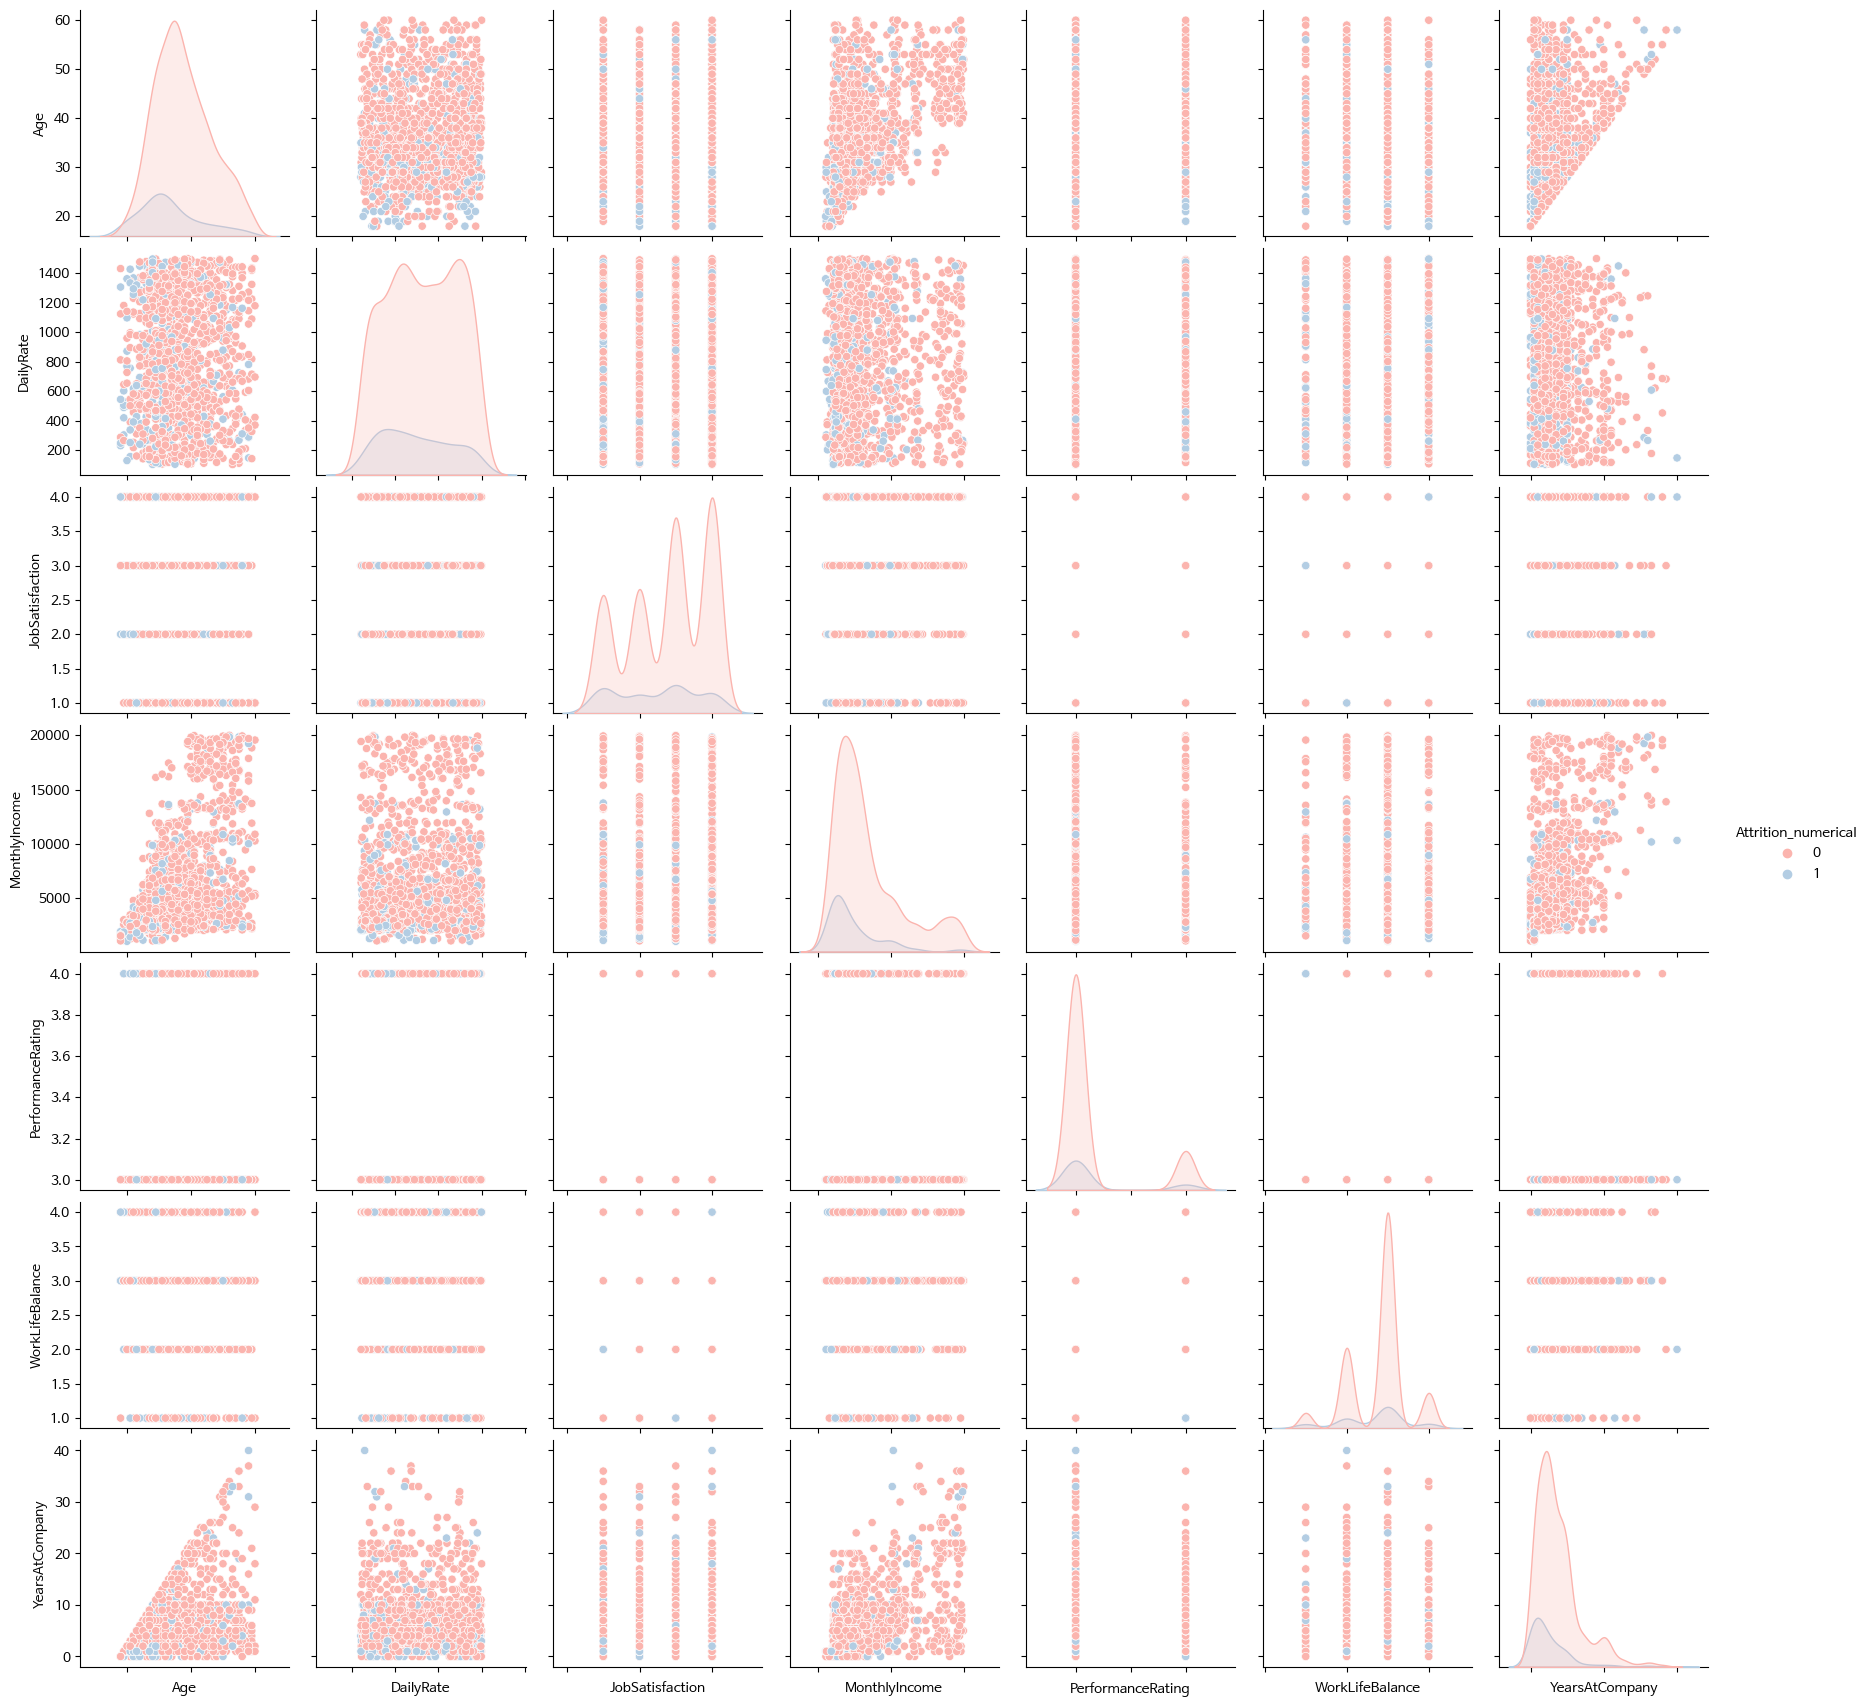

In [ ]:
numerical = [u'Age', u'DailyRate', u'JobSatisfaction', u'MonthlyIncome', u'PerformanceRating',
             u'WorkLifeBalance', u'YearsAtCompany', u'Attrition_numerical']

g = sns.pairplot(attrition[numerical], hue = 'Attrition_numerical', palette = 'Pastel1', diag_kind = 'kde', diag_kws = dict(shade = True))
g.set(xticklabels = [])

In [ ]:
num_feat = attrition_num.columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
  corr = pearsonr(attrition_num[comb[0]], attrition_num[comb[1]])[0]
  corr_num_feat = np.append(corr_num_feat, corr)

In [ ]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['JobLevel', 'MonthlyIncome']], dtype='<U24')

In [ ]:
# plotly 안 보이는 문제 해결

import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.renderers
pio.renderers.default = 'colab'
pio.renderers

data = [
    go.Heatmap(
        z=attrition_num.astype(float).corr().values, # 피어슨 상관계수
        x=attrition_num.columns.values,
        y=attrition_num.columns.values,
        colorscale='peach',
        reversescale = False,
        opacity = 1.0

    )
]


layout = go.Layout(
    title='숫자형 Feature 들의 피어슨 상관계수',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,

)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')



In [ ]:
attrition_num = attrition_num.drop(np.unique(high_corr_num[:, 0]), axis = 1, errors='ignore')

In [ ]:
attrition_cat_dummies.nunique().sort_values()

BusinessTravel_Non-Travel            2
MaritalStatus_Single                 2
MaritalStatus_Married                2
MaritalStatus_Divorced               2
JobRole_Sales Representative         2
JobRole_Sales Executive              2
JobRole_Research Scientist           2
JobRole_Research Director            2
JobRole_Manufacturing Director       2
JobRole_Manager                      2
JobRole_Laboratory Technician        2
JobRole_Human Resources              2
JobRole_Healthcare Representative    2
Gender_Male                          2
Gender_Female                        2
EducationField_Technical Degree      2
EducationField_Other                 2
EducationField_Medical               2
EducationField_Marketing             2
EducationField_Life Sciences         2
EducationField_Human Resources       2
Department_Sales                     2
Department_Research & Development    2
Department_Human Resources           2
BusinessTravel_Travel_Rarely         2
BusinessTravel_Travel_Fre

In [ ]:
attrition_cat_dummies.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1, var2):
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames = None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape)-1
  return (stat/(obs*mini))

In [ ]:
rows = []

for var1 in attrition_cat_dummies:
  col = []
  for var2 in attrition_cat_dummies:
    cramers = cramers_V(attrition_cat_dummies[var1], attrition_cat_dummies[var2])
    col.append(round(cramers,2))
  rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = attrition_cat_dummies.columns, index = attrition_cat_dummies.columns)

df.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
BusinessTravel_Non-Travel,0.99,0.03,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
BusinessTravel_Travel_Frequently,0.03,1.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
BusinessTravel_Travel_Rarely,0.27,0.56,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
Department_Human Resources,0.00,0.00,0.00,0.98,0.08,0.02,0.40,0.00,0.00,0.00,...,0.00,0.00,0.01,0.01,0.00,0.0,0.0,0.0,0.0,0.0
Department_Research & Development,0.00,0.00,0.00,0.08,1.00,0.82,0.03,0.02,0.23,0.03,...,0.06,0.03,0.13,0.54,0.11,0.0,0.0,0.0,0.0,0.0


In [ ]:
attrition_final = pd.concat([attrition_num, attrition_cat_dummies], axis =1)

In [ ]:
attrition_final.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,4,5993,19479,...,0,0,0,1,0,0,0,1,0,1
1,49,279,8,1,3,61,2,2,5130,24907,...,0,0,1,0,0,0,1,0,1,0
2,37,1373,2,2,4,92,2,3,2090,2396,...,0,0,0,0,0,0,0,1,0,1
3,33,1392,3,4,4,56,3,3,2909,23159,...,0,0,1,0,0,0,1,0,0,1
4,27,591,2,1,1,40,3,2,3468,16632,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
data = [go.Bar(
    x = attrition['Attrition'].value_counts().index.values,
    y = attrition['Attrition'].value_counts().values
)]

py.iplot(data, filename = 'basic-bar')

In [ ]:
target = attrition['Attrition_numerical']

In [ ]:
from sklearn.model_selection import train_test_split

train, test, target_train, target_val = train_test_split(attrition_final,
                                                         target,
                                                         train_size = 0.80,
                                                         random_state = 0);

In [ ]:
oversampler=SMOTE(random_state=0)
smote_train, smote_target = oversampler.fit_resample(train,target_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

rf_params = {'n_estimators': [10, 100],
             'max_depth' : [4,8,10,12],
             'min_samples_leaf' : [2,4,8,12],
             'max_features': [0.1,0.3,0.5]
             }

rf_clf = RandomForestClassifier(random_state = 0, n_jobs =-1)
grid_cv = GridSearchCV(rf_clf, param_grid = rf_params, cv =3, n_jobs = -1)
grid_cv.fit(smote_train, smote_target)

print('Best Hyper Parameters ; ', grid_cv.best_params_)
print('Best Predict Accuracy : {:.4f}'.format(grid_cv.best_score_))

Best Hyper Parameters ;  {'max_depth': 12, 'max_features': 0.1, 'min_samples_leaf': 2, 'n_estimators': 100}
Best Predict Accuracy : 0.9135


In [ ]:
seed = 0
rf_params = {
    'n_jobs' : -1,
    'n_estimators' : 100,
    'max_features' : 0.1,
    'max_depth' : 12,
    'min_samples_leaf' : 2,
    'random_state' : seed,
    'verbose' : 0
}

In [ ]:
rf = RandomForestClassifier(**rf_params)

In [ ]:
rf.fit(smote_train, smote_target)
rf_predictions = rf.predict(test)
print('Accuracy score : {}'.format(accuracy_score(target_val, rf_predictions)))
print('='*60)
print(classification_report(target_val, rf_predictions))

Accuracy score : 0.8707482993197279
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       245
           1       0.76      0.33      0.46        49

    accuracy                           0.87       294
   macro avg       0.82      0.65      0.69       294
weighted avg       0.86      0.87      0.85       294



In [ ]:
from sklearn.model_selection import GridSearchCV

gb_params = {
    'n_estimators' : [1000, 1500],
    'max_depth' : [4,6],
    'min_samples_leaf' : [2, 4],
    'max_features' : [0.7, 0.9],
    'learning_rate': [0.25, 0.3]
}


gb_clf = GradientBoostingClassifier(random_state = 0)
grid_cv = GridSearchCV(gb_clf, param_grid = gb_params, cv =3, n_jobs = -1)
grid_cv.fit(smote_train, smote_target)

print('Best Hyper Parameters : ', grid_cv.best_params_)
print('Best Predict Accuracy : {:.4f}'.format(grid_cv.best_score_))

Best Hyper Parameters :  {'learning_rate': 0.3, 'max_depth': 6, 'max_features': 0.9, 'min_samples_leaf': 4, 'n_estimators': 1000}
Best Predict Accuracy : 0.9064


In [ ]:
seed = 0
gb_params = {
    'n_estimators' : 1000,
    'max_features' : 0.9,
    'learning_rate' : 0.3,
    'max_depth' : 6,
    'min_samples_leaf' : 4,
    'random_state' : seed,
    'verbose' : 0
}

In [ ]:
gb = GradientBoostingClassifier(**gb_params)
gb.fit(smote_train, smote_target)
gb_predictions = gb.predict(test)

In [ ]:
print('Accuracy score : {}'.format(accuracy_score(target_val, gb_predictions)))
print(classification_report(target_val, gb_predictions))

Accuracy score : 0.8571428571428571
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       245
           1       0.63      0.35      0.45        49

    accuracy                           0.86       294
   macro avg       0.75      0.65      0.68       294
weighted avg       0.84      0.86      0.84       294



In [ ]:

trace = go.Scatter(
    y = rf.feature_importances_,
    x = attrition_final.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = attrition_final.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

 DATA : https://www.kaggle.com/code/arthurtok/employee-attrition-via-ensemble-tree-based-methods